In [3]:
import os
import sys
import torch
import numpy as np
from torch import matmul as m
from matplotlib import pyplot as plt
from sdes import SDE,ConstantDiffusion,TwoDimensionalSynDrift,DoubleWellDrift,MaxDiffusion,LinearDrift1D
from torch.autograd.functional import jacobian

from torch.distributions import MultivariateNormal

sys.path.insert(0,".")

from gpytorch.kernels import (
    RBFKernel, 
    ScaleKernel,
    PolynomialKernel
)

from utils import define_grid_ranges,define_mesh_points
from gps import MultivariateNormal,white_noise_kernel
from sde_sparse_gp import SparseGPSDE
from sde_gp_em import OU, maximization

## Generate SDEs

In [4]:
dt = 0.002
number_of_steps = 5000
num_dense_steps_in_bridge = 10
num_paths = 3
sigma = 1.

#x_0 = torch.rand((1,)).unsqueeze(-1)
#real_drift = LinearDrift1D(a=4.)
#diffusion = MaxDiffusion()
#diffusion = ConstantDiffusion(sigma=sigma)

x_0 = torch.rand((1,)).unsqueeze(-1)
real_drift = DoubleWellDrift(a=4.,b=4.)
diffusion = MaxDiffusion()
#diffusion = ConstantDiffusion(sigma=sigma)

#x_0 = torch.rand((2,)).unsqueeze(0)
#real_drift = TwoDimensionalSynDrift()
#diffusion = ConstantDiffusion(sigma=sigma)

sde = SDE(real_drift,diffusion,dt=dt)
dense_path_realization = sde.simulate(x_0, number_of_steps, num_paths=num_paths)
dense_path_realization = dense_path_realization[0,:,:]

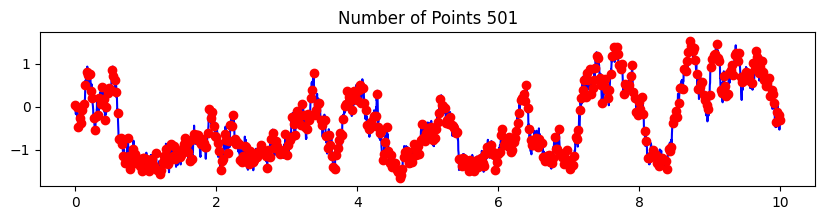

In [5]:
#=============================================
#DEFINE SPARSE OBSERVATIONS
#=============================================
number_of_steps = dense_path_realization.size(0)
dense_time = torch.arange(0,number_of_steps)*dt
max_time = number_of_steps*dt
observation_index = range(0,number_of_steps,num_dense_steps_in_bridge)
sparse_observation_time = dense_time[observation_index]
sparse_observations = dense_path_realization[observation_index]
plt.figure(figsize=(10,2))
plt.title(f"Number of Points {sparse_observation_time.size(0)}")
plt.plot(dense_time,dense_path_realization[:,0],"b-")
plt.plot(sparse_observation_time,sparse_observations[:,0],"ro")
plt.show()

In [10]:
nmc_x = 100
nmc_t = 300
num_inducing_points = 10
num_evaluation_points = 1000
dimensions = sparse_observations.size(1)
kernels_parameters = [(.1,1.),(1.,1.)]

EPSILON = 1e-3

In [11]:
#=============================================
# SPARSE GP DENSE DRIFT ESTIMATION
#=============================================
# where to evaluate the drift function
ranges_ = define_grid_ranges(dense_path_realization,ignore_percentatge=0.02)
evaluation_points = define_mesh_points(total_points=num_evaluation_points,
                                        n_dims=dimensions,
                                        ranges=ranges_)
sparse_gp_sde = SparseGPSDE(sparse_observations,
                            dt=dt,
                            #kernel_parameters = kernels_parameters,
                            kernels=[PolynomialKernel(power=4)],
                            num_inducing_points=num_inducing_points)
sparse_gp_sde.inference(diffusion)

# do not accumulate grdients
for kernel in sparse_gp_sde.kernels:
    kernel.eval()
    
F = sparse_gp_sde(evaluation_points)
f_x = F[:,0]

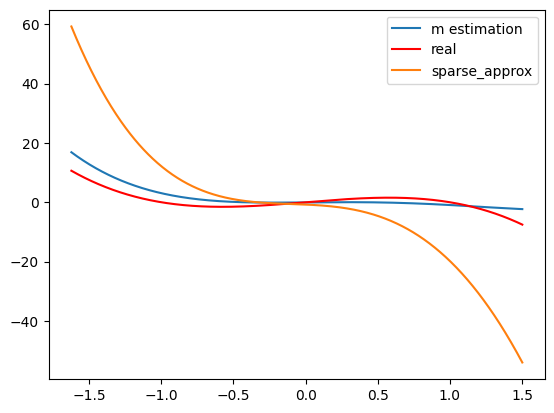

In [12]:
#========================================
# EM STEPS
#========================================
drift = sparse_gp_sde
mc_times = torch.rand((nmc_t,))*sparse_observation_time.max() # random times
full_times = torch.linspace(0.,max_time-2*dt,200) # times on grid
#mc_times = full_times
monte_carlo_points_,m_t,C_t,A_x,g_x = OU(mc_times,
                                         sparse_observation_time,
                                         sparse_observations,
                                         diffusion,
                                         drift=real_drift,
                                         nmc_x=nmc_x,
                                         evidence=False,
                                         EPSILON=EPSILON)

F_x = maximization(evaluation_points,
                   monte_carlo_points_,
                   sparse_gp_sde.inducing_points,
                   sparse_gp_sde.kernels,
                   A_x,
                   g_x,
                   diffusion,
                   option_2=True,
                   EPSILON=EPSILON)

real_drift_ = real_drift(evaluation_points)
plt.plot(evaluation_points,F_x[:,0].detach().numpy(),label="m estimation")
plt.plot(evaluation_points,real_drift_[:,0].detach().numpy(),"r-",label="real")
plt.plot(evaluation_points,f_x.detach().numpy(),label="sparse_approx")
plt.legend(loc="best")
plt.savefig("first_em_step.png")


In [7]:
# Maximixation Step
def current_drift(x):
    F_x = maximization(x,
                       monte_carlo_points_,
                       sparse_gp_sde.inducing_points,
                       sparse_gp_sde.kernels,
                       A_x,
                       g_x,
                       diffusion,
                       option_2=True,
                       EPSILON=EPSILON)
    return F_x
F_x = current_drift(evaluation_points)

monte_carlo_points_,m_t,C_t,A_x,g_x = OU(mc_times,
                                         sparse_observation_time,
                                         sparse_observations,
                                         diffusion,
                                         drift=current_drift,
                                         nmc_x=nmc_x,
                                         evidence=False,
                                         EPSILON=EPSILON)


In [8]:
F_x = current_drift(evaluation_points)

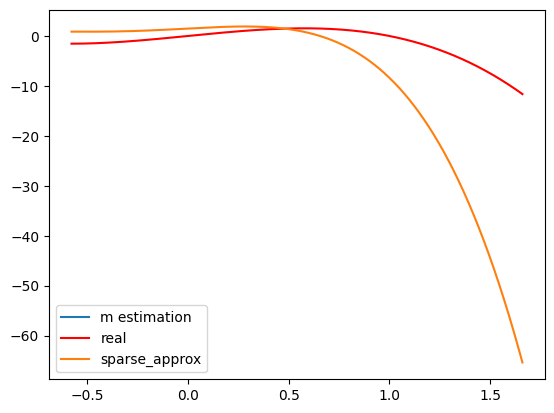

In [9]:
real_drift_ = real_drift(evaluation_points)
plt.plot(evaluation_points,F_x[:,0].detach().numpy(),label="m estimation")
plt.plot(evaluation_points,real_drift_[:,0].detach().numpy(),"r-",label="real")
plt.plot(evaluation_points,f_x.detach().numpy(),label="sparse_approx")
plt.legend(loc="best")
plt.savefig("first_em_step.png")